## Import Libs

In [1]:
import os
import random
import gc
import time
import copy
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler, CosineAnnealingLR
import timm

from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

import warnings # 避免一些可以忽略的报错
warnings.filterwarnings('ignore')
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

/data1/hjs/anaconda3/envs/transformers/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## CONFIG

In [2]:
is_debug = False
use_803098 = False
use_401059_val = True
use_1977_train = True # 2024_0 + 2024_1 + 2020_1
use_10999_train = False # 2024_0 + 2024_1 + 2020_1 + 2019_1

class CONFIG:
    seed = 308
    epochs = 32 if not is_debug else 2
    
    train_batch_size = 16
    valid_batch_size = 32
    img_size = [128, 128]
    now_cv = 0
    n_classes = 1
    n_folds = 5
    
    n_accumulate = 1.0
    n_workers = os.cpu_count()
    
    formatted_time = None
    ckpt_save_path = None

    learning_rate = 1e-3 * train_batch_size * n_accumulate / 32
    # learning_rate = 1e-5 * train_batch_size / 32 # eva02
    total_sample = 1977
    T_max = total_sample * 0.8 * epochs / train_batch_size // n_accumulate# 401059
    min_lr = 1e-6
    weight_decay = 1e-6
    scheduler = "CosineAnnealingWithWarmupLR" # 'CosineAnnealingLR'
    DataParallel = True

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    """
    tf_efficientnet_b0_ns
    convnext_atto_ols.a2_in1k
    tiny_vit_21m_512.dist_in22k_ft_in1k
    eva02_base_patch14_224.mim_in22k
    tf_efficientnetv2_s.in21k_ft_in1k
    convnextv2_tiny.fcmae_ft_in22k_in1k_384

    efficientvit_b0.r224_in1k
    """
    model_name = "tiny_vit_21m_512.dist_in22k_ft_in1k"
    is_pretrained = False
    backbone_grad = True
    use_gempool = False
    ckpt_paths = "/data1/hjs/pythonProject/pythonProject/ISIC2024/ckpt"

    old_my_train_csv = "/data1/hjs/pythonProject/pythonProject/ISIC2024/my_train.csv"
    my_train_csv = "/data1/hjs/pythonProject/pythonProject/ISIC2024/new_extend_train.csv" if use_803098 else "/data1/hjs/pythonProject/pythonProject/ISIC2024/my_train.csv"
    train_img_dir = "/data1/hjs/pythonProject/pythonProject/ISIC2024/image"
    new_train_img_dir = "/data1/hjs/pythonProject/pythonProject/ISIC2024/new_1_imgs"
    train_1977_csv = "/data1/hjs/pythonProject/pythonProject/ISIC2024/train_1977.csv"
    train_793_csv = "/data1/hjs/pythonProject/pythonProject/ISIC2024/train_793.csv"
    train_10999_csv = "/data1/hjs/pythonProject/pythonProject/ISIC2024/train_10999.csv"

if CONFIG.DataParallel:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
    print("IN DataParallel!")
else:
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    print("NO IN DataParallel!")

IN DataParallel!


## Set Random Seed

In [3]:
def set_seed(seed=308):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(CONFIG.seed)

## Data Progress

In [4]:
# root_dir = "/kaggle/input/isic-2024-challenge/train-image/image"
# img_ids = os.listdir(root_dir)

# min_size = 9999
# max_size = 0
# n_0_64 = 0
# n_64_96 = 0
# n_96_160 = 0
# n_160_224 = 0
# n_224_269 = 0
# for img_id in tqdm(img_ids):
#     path = os.path.join(root_dir, img_id)
#     a = Image.open(path)
#     s = np.array(a).shape[0]
#     if s > max_size:
#         max_size = s
#     if s < min_size:
#         min_size = s
        
#     if s >= 0 and s < 64:
#         n_0_64 += 1
#     elif s >= 64 and s < 96:
#         n_64_96 += 1
#     elif s >= 96 and s < 160:
#         n_96_160 += 1
#     elif s >= 160 and s < 224:
#         n_160_224 += 1
#     elif s >= 224:
#         n_224_269 += 1
        
# print(f"max_size : {max_size}") # max_size : 269
# print(f"min_size : {min_size}") # min_size : 41

# print(f"n_0_64    : {n_0_64}")    # 86
# print(f"n_64_96   : {n_64_96}")   # 3461
# print(f"n_96_160  : {n_96_160}")  # 368914
# print(f"n_160_224 : {n_160_224}") # 28305
# print(f"n_224_269 : {n_224_269}") # 293

# """
# 以上代码运行时间 : 37:20
# """

In [5]:
if os.path.exists(CONFIG.my_train_csv):
    train = pd.read_csv(CONFIG.my_train_csv)
else:
    train = pd.read_csv(CONFIG.train_csv)

valid = pd.read_csv(CONFIG.old_my_train_csv)
train

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,kfold
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,2
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,2
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,4
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,4
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988,2
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820,2
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416,1
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,4


In [6]:
if not os.path.exists(CONFIG.my_train_csv):
    print("贴 KFold....")
    # 设置StratifiedKFold参数
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=308)

    # 创建一个新的列来保存KFold标签
    train['kfold'] = -1

    # 遍历每个fold并分配标签
    for fold, (train_idx, val_idx) in enumerate(skf.split(train, train['target'])):
        train.loc[val_idx, 'kfold'] = fold
train

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,kfold
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,2
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,2
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,4
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,4
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988,2
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820,2
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416,1
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,4


In [7]:
if use_803098:
    new_train = train
else:
    if use_1977_train:
        new_train = pd.read_csv(CONFIG.train_1977_csv)
    elif use_10999_train:
        new_train = pd.read_csv(CONFIG.train_10999_csv)
    else:
        new_train = pd.read_csv(CONFIG.train_793_csv)
    # train_0 = train[train["target"] != 1] # 400666 rows × 56 columns
    # train_1 = train[train["target"] == 1] # 393 rows × 56 columns

    # train_0 = train_0.reset_index(drop=True)
    # train_1 = train_1.reset_index(drop=True)

    # # train_1[train_1["kfold"] == 4] # [78, 79, 79, 79, 78] sum --> 393

    # # 0 : 1 ---> 1020 : 1

    # # 每个 fold 取 80 个样本 总共 400
    # some_train_0 = []
    # for fold in range(CONFIG.n_folds):
    #     _tmp = train_0[train_0["kfold"] == fold].reset_index(drop=True).iloc[:200, :]
    #     some_train_0.append(_tmp)

    # some_train_0 = pd.concat(some_train_0).reset_index(drop=True)
    # some_train_0

    # new_train = pd.concat([some_train_0, train_1]).reset_index(drop=True)
    # new_train = pd.concat([new_train, train_1_2020]).reset_index(drop=True)
    # new_train = new_train.sample(frac=1).reset_index(drop=True)
new_train

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,kfold
0,ISIC_0088682,0,IP_5148328,40.0,female,anterior torso,3.42,TBP tile: close-up,3D: XP,13.534873,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.900311,0
1,ISIC_1009042,1,IP_9954107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2,ISIC_9210255,1,IP_4321822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,ISIC_0075969,0,IP_5117525,40.0,female,posterior torso,9.05,TBP tile: close-up,3D: XP,21.315824,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999905,2
4,ISIC_0091648,0,IP_0658218,75.0,male,anterior torso,2.79,TBP tile: close-up,3D: XP,19.691264,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.965012,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1972,ISIC_5985180,1,IP_9801595,60.0,male,head/neck,2.70,TBP tile: close-up,3D: white,16.871130,...,Malignant::Malignant melanocytic proliferation...,Malignant,Malignant melanocytic proliferations (Melanoma),Melanoma Invasive,"Melanoma Invasive, Associated with a nevus",NaN,NaN,0.5,74.760990,0
1973,ISIC_8617277,1,IP_3281766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
1974,ISIC_7834218,1,IP_8241654,50.0,female,anterior torso,4.11,TBP tile: close-up,3D: XP,21.398280,...,Malignant::Malignant melanocytic proliferation...,Malignant,Malignant melanocytic proliferations (Melanoma),Melanoma in situ,NaN,NaN,NaN,NaN,100.000000,0
1975,ISIC_0087476,0,IP_7770500,55.0,male,posterior torso,2.62,TBP tile: close-up,3D: white,20.979380,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,1


## Dataset and DataLoader

In [8]:
# class HairAugmentation(A.ImageOnlyTransform):
#     def __init__(self, num_hairs=5, hair_color=(0, 0, 0), always_apply=False, p=0.5):
#         super(HairAugmentation, self).__init__(always_apply, p)
#         self.num_hairs = num_hairs
#         self.hair_color = hair_color

#     def apply(self, img, **params):
#         img = img.copy()
#         h, w, _ = img.shape
        
#         for _ in range(self.num_hairs):
#             # Randomly choose the position and size of the hair
#             x1, y1 = random.randint(0, w), random.randint(0, h)
#             x2, y2 = random.randint(0, w), random.randint(0, h)
#             thickness = random.randint(1, 1)  # Making the hair thinner
#             img = cv2.line(img, (x1, y1), (x2, y2), self.hair_color, thickness)
        
#         return img

#     def get_params_dependent_on_targets(self, params):
#         return {}

#     def get_transform_init_args_names(self):
#         return ("num_hairs", "hair_color")
    
# # HairAugmentation(num_hairs=10, hair_color=(0, 0, 0), p=1.0),

class HairAugmentation(A.ImageOnlyTransform):
    def __init__(self, num_hairs_range=(5, 15), hair_color_range=((0, 0, 0), (255, 255, 255)), always_apply=False, p=0.5):
        super(HairAugmentation, self).__init__(always_apply, p)
        self.num_hairs_range = num_hairs_range
        self.hair_color_range = hair_color_range

    def apply(self, img, **params):
        img = img.copy()
        h, w, _ = img.shape

        num_hairs = random.randint(self.num_hairs_range[0], self.num_hairs_range[1])
        hair_color = (
            random.randint(self.hair_color_range[0][0], self.hair_color_range[1][0]),
            random.randint(self.hair_color_range[0][1], self.hair_color_range[1][1]),
            random.randint(self.hair_color_range[0][2], self.hair_color_range[1][2])
        )

        for _ in range(num_hairs):
            # Randomly choose the position and size of the hair
            x1, y1 = random.randint(0, w), random.randint(0, h)
            x2, y2 = random.randint(0, w), random.randint(0, h)
            thickness = random.randint(1, 1)  # Making the hair thinner
            img = cv2.line(img, (x1, y1), (x2, y2), hair_color, thickness)

        return img

    def get_params_dependent_on_targets(self, params):
        return {}

    def get_transform_init_args_names(self):
        return ("num_hairs_range", "hair_color_range")
    
# HairAugmentation(num_hairs_range=(5, 15), hair_color_range=((0, 0, 0), (255, 255, 255)), p=1.0)

In [9]:
def transform(img):
    composition = A.Compose([
        A.Resize(CONFIG.img_size[0], CONFIG.img_size[1]),
        ToTensorV2(),
    ])
    return composition(image=img)["image"]

# def transform_train(img):
#     composition = A.Compose([
#         A.Resize(CONFIG.img_size[0], CONFIG.img_size[1]),
#         HairAugmentation(num_hairs_range=(5, 15), hair_color_range=((0, 0, 0), (255, 255, 255)), p=0.5),
#         ToTensorV2(),
#     ])
#     return composition(image=img)["image"]


# def transform_val(img):
#     composition = A.Compose([
#         A.Resize(CONFIG.img_size[0], CONFIG.img_size[1]),
#         ToTensorV2(),
#     ])
#     return composition(image=img)["image"]

def transform_train(img):
    composition = A.Compose([
        HairAugmentation(num_hairs_range=(5, 15), hair_color_range=((0, 0, 0), (255, 255, 255)), p=0.5),
        A.Transpose(p=0.5),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightness(limit=0.2, p=0.75),
        A.RandomContrast(limit=0.2, p=0.75),
        A.OneOf([
            A.MotionBlur(blur_limit=5),
            A.MedianBlur(blur_limit=5),
            A.GaussianBlur(blur_limit=5),
            A.GaussNoise(var_limit=(5.0, 30.0)),
        ], p=0.7),

        A.OneOf([
            A.OpticalDistortion(distort_limit=1.0),
            A.GridDistortion(num_steps=5, distort_limit=1.),
            A.ElasticTransform(alpha=3),
        ], p=0.7),

        A.CLAHE(clip_limit=4.0, p=0.7),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
        A.Resize(CONFIG.img_size[0], CONFIG.img_size[1]),
        A.Cutout(max_h_size=int(CONFIG.img_size[0] * 0.375), max_w_size=int(CONFIG.img_size[1] * 0.375), num_holes=1, p=0.7),    
        A.Normalize(),
        ToTensorV2(),
    ])
    return composition(image=img)["image"]


def transform_val(img):
    composition = A.Compose([
        A.Resize(CONFIG.img_size[0], CONFIG.img_size[1]),
        A.Normalize(),
        ToTensorV2(),
    ])
    return composition(image=img)["image"]

# transform_train = A.Compose([
#     A.Transpose(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightness(limit=0.2, p=0.75),
#     A.RandomContrast(limit=0.2, p=0.75),
#     A.OneOf([
#         A.MotionBlur(blur_limit=5),
#         A.MedianBlur(blur_limit=5),
#         A.GaussianBlur(blur_limit=5),
#         A.GaussNoise(var_limit=(5.0, 30.0)),
#     ], p=0.7),

#     A.OneOf([
#         A.OpticalDistortion(distort_limit=1.0),
#         A.GridDistortion(num_steps=5, distort_limit=1.),
#         A.ElasticTransform(alpha=3),
#     ], p=0.7),

#     A.CLAHE(clip_limit=4.0, p=0.7),
#     A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
#     A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
#     A.Resize(CONFIG.img_size[0], CONFIG.img_size[1]),
#     A.Cutout(max_h_size=int(CONFIG.img_size[0] * 0.375), max_w_size=int(CONFIG.img_size[1] * 0.375), num_holes=1, p=0.7),    
#     A.Normalize(),
#     ToTensorV2(),
# ])

# transform_val = A.Compose([
#     A.Resize(CONFIG.img_size[0], CONFIG.img_size[1]),
#     A.Normalize(),
#     ToTensorV2(),
# ])

In [10]:
class MyDataset(Dataset):
    def __init__(self, df, transform=None):
        super().__init__()
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx, :]
        img_id = row.isic_id + ".jpg"
        label = torch.tensor(row.target, dtype=torch.float32)
        
        if use_803098:
            if label.item() == 1:
                img_path = os.path.join(CONFIG.new_train_img_dir, img_id)
            else:
                img_path = os.path.join(CONFIG.train_img_dir, img_id)
        else:
            img_path = os.path.join(CONFIG.train_img_dir, img_id)
        img = Image.open(img_path)
        img = np.array(img)

        if self.transform != None:
            img = self.transform(img)

        return img, label

In [11]:
def prepare_loaders(df, fold=0):
    df_train = df[df["kfold"] != fold]
    if use_401059_val:
        df_valid = valid[valid["kfold"] == fold]
    else:
        df_valid = df[df["kfold"] == fold]
    
    train_datasets = MyDataset(df=df_train, transform=transform_train)
    valid_datasets = MyDataset(df=df_valid, transform=transform_val)
    
    train_loader = DataLoader(train_datasets, batch_size=CONFIG.train_batch_size, num_workers=CONFIG.n_workers, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_datasets, batch_size=CONFIG.valid_batch_size, num_workers=CONFIG.n_workers, shuffle=False, pin_memory=True)
    
    
    return train_loader, valid_loader

In [12]:
# train_loader, valid_loader = prepare_loaders(train)
# x, y = next(iter(train_loader))
# x.shape

## Evaluation

In [13]:
def compute_pAUC(y_true, y_scores, min_tpr=0.8):
    """
    计算pAUC, 特别是高于min_tpr (例如0.8) 部分的面积。

    参数:
    y_true (array-like): 真实标签 (0或1) 。
    y_scores (array-like): 预测概率或得分。
    min_tpr (float): 最小TPR阈值, 默认值为0.8。

    返回:
    pAUC (float): ROC曲线在min_tpr以上部分的面积。
    """
    # 计算fpr, tpr, 和阈值
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    # 找到高于min_tpr的部分
    idx = np.where(tpr >= min_tpr)[0]
    
    if len(idx) == 0:
        return 0.0
    
    # 截取高于min_tpr的部分
    fpr = fpr[idx]
    tpr = tpr[idx]
    # 确保有足够的点进行AUC计算
    if len(fpr) < 2 or len(tpr) < 2:
        return 0.0
    
    # 计算高于min_tpr部分的AUC
    pAUC = auc(fpr, tpr)
    # 归一化pAUC使其在[0, 0.2]范围内
    max_possible_auc = (1 - min_tpr)
    pAUC_normalized = pAUC * max_possible_auc
    
    return pAUC_normalized

"""
# 假设y_true是实际标签, y_scores是模型预测的得分
y_true = [0, 0, 1, 1]
y_scores = [0.1, 0.4, 0.35, 0.8]

pAUC = compute_pAUC(y_true, y_scores)
print(f"pAUC: {pAUC:.4f}")
"""
y_true = [0.0, 0.0, 1.0, 1.0]
y_scores = [0.0, 0.0, 0.9, 0.1]

pAUC = compute_pAUC(y_true, y_scores)
print(f"pAUC: {pAUC:.4f}")

pAUC: 0.2000


## DL Model

In [14]:
def updata_req_grad(models, requires_grad=True):
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad

In [15]:
class GeMPool(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeMPool, self).__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
    
    def gem(self, x, p=3, eps=1e-6):
        return torch.mean(x.clamp(min=eps).pow(p), dim=(-2, -1)).pow(1./p)
    
    def __repr__(self):
        return self.__class__.__name__ + f'(p={self.p.data.tolist()[0]:.4f}, eps={self.eps})'

In [16]:
class ISIC2024Model(nn.Module):
    def __init__(self):
        super(ISIC2024Model, self).__init__()
        self.backbone = timm.create_model(model_name=CONFIG.model_name, 
                                          pretrained=CONFIG.is_pretrained)
        self.backbone.load_state_dict(torch.load(os.path.join(CONFIG.ckpt_paths, CONFIG.model_name + ".bin")))

        if "efficientnet" in CONFIG.model_name:
            in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            if CONFIG.use_gempool:
                self.backbone.global_pool = GeMPool()
        elif "convnext" in CONFIG.model_name or "tiny_vit" in CONFIG.model_name:
            in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()
        elif "eva" in CONFIG.model_name:
            in_features = 768
        elif "efficientvit" in CONFIG.model_name:
            in_features = self.backbone.head.classifier[4].in_features
            self.backbone.head.classifier[4] = nn.Identity()

        self.head = nn.Sequential(
            nn.Linear(in_features, CONFIG.n_classes)
        )
        
        
    def forward(self, x):
        _tmp = self.backbone(x)
        output = self.head(_tmp)
        return output

In [17]:
model = ISIC2024Model()
model

ISIC2024Model(
  (backbone): TinyVit(
    (patch_embed): PatchEmbed(
      (conv1): ConvNorm(
        (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (act): GELU()
      (conv2): ConvNorm(
        (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (stages): Sequential(
      (0): ConvLayer(
        (blocks): Sequential(
          (0): MBConv(
            (conv1): ConvNorm(
              (conv): Conv2d(96, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (act1): GELU()
            (conv2): ConvNorm(
              (conv): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), 

## Train and Valid Function

In [18]:
criterion = nn.BCELoss()

"""
a = torch.tensor([0, 0, 1, 1]).float()
b = torch.tensor([0.7, 0.2, 0.5, 0.3]).float()
c = torch.tensor([[0.7], [0.2], [0.5], [0.3]]).float()
criterion(a, b)
"""

'\na = torch.tensor([0, 0, 1, 1]).float()\nb = torch.tensor([0.7, 0.2, 0.5, 0.3]).float()\nc = torch.tensor([[0.7], [0.2], [0.5], [0.3]]).float()\ncriterion(a, b)\n'

In [19]:
def train_one_epoch(model, optimizer, scheduler, train_loader, epoch):
    model.train()
    
    y_preds = []
    y_trues = []
    
    dataset_size = 0
    running_loss = 0.0
    bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (images, labels) in bar:
        optimizer.zero_grad()
        
        batch_size = images.size(0)
        if CONFIG.DataParallel:
            images = images.cuda().float()
            labels = labels.cuda().float()
        else:
            images = images.to(CONFIG.device, dtype=torch.float)
            labels = labels.to(CONFIG.device, dtype=torch.float)
            
        outputs = model(images)
        outputs = F.sigmoid(outputs)
        loss = criterion(outputs.flatten(), labels) / CONFIG.n_accumulate
        loss.backward()
        
        if (step + 1) % CONFIG.n_accumulate == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
        y_preds.append(outputs.flatten().detach().cpu().numpy())
        y_trues.append(labels.detach().cpu().numpy())
        train_cv = compute_pAUC(np.concatenate(y_trues), np.concatenate(y_preds))

        running_loss += (loss.item() * batch_size)

        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch,
                        Train_Loss=epoch_loss,
                        Train_CV_pAUC=train_cv,
                        LR=optimizer.param_groups[0]['lr'])
    # 确保在最后一个累积周期后，进行一次参数更新
    if (step + 1) % CONFIG.n_accumulate != 0:
        optimizer.step()
        optimizer.zero_grad()
        if scheduler is not None:
                scheduler.step()
        
    return epoch_loss, train_cv

In [20]:
@torch.inference_mode()
def valid_one_epoch(model, optimizer, valid_loader, epoch):
    model.eval()
    
    y_preds = []
    y_trues = []
    dataset_size = 0
    running_loss = 0.0
    bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
    with torch.no_grad():
        for step, (images, labels) in bar:
            batch_size = images.size(0)
            if CONFIG.DataParallel:
                images = images.cuda().float()
                labels = labels.cuda().float()
            else:
                images = images.to(CONFIG.device, dtype=torch.float)
                labels = labels.to(CONFIG.device, dtype=torch.float)

            outputs = model(images)
            outputs = F.sigmoid(outputs)
            loss = criterion(outputs.flatten(), labels) / CONFIG.n_accumulate

            y_preds.append(outputs.flatten().detach().cpu().numpy())
            y_trues.append(labels.detach().cpu().numpy())
            valid_cv = compute_pAUC(np.concatenate(y_trues), np.concatenate(y_preds))
        
            running_loss += (loss.item() * batch_size)

            dataset_size += batch_size

            epoch_loss = running_loss / dataset_size

            bar.set_postfix(Epoch=epoch,
                            Valid_Loss=epoch_loss,
                            Valid_CV_pAUC=valid_cv,
                            LR=optimizer.param_groups[0]['lr'])
        

        y_preds = np.concatenate(y_preds)
        y_trues = np.concatenate(y_trues)
        cv = compute_pAUC(y_trues, y_preds) 
    
    return epoch_loss, cv

In [21]:
# 获取当前时间的时间戳
current_time = time.time()
print("当前时间戳:", current_time)

# 将时间戳转换为本地时间结构
local_time = time.localtime(current_time)

# 格式化本地时间
CONFIG.formatted_time = time.strftime('%Y-%m-%d_%H:%M:%S', local_time)
print("当前时间:", CONFIG.formatted_time)

CONFIG.ckpt_save_path = f"output/{CONFIG.formatted_time}_{CONFIG.model_name}_output"
if os.path.exists(CONFIG.ckpt_save_path) is False:
    os.makedirs(CONFIG.ckpt_save_path)

当前时间戳: 1723977111.049588
当前时间: 2024-08-18_18:31:51


In [22]:
def run_training(fold, model, optimizer, scheduler, train_loader, valid_loader, num_epochs=CONFIG.epochs, now_cv=CONFIG.now_cv):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {} x {}\n".format(torch.cuda.get_device_name(), torch.cuda.device_count()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_cv = now_cv
    best_model_path = None
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1):
        gc.collect()
        train_epoch_loss, train_epoch_cv = train_one_epoch(model, optimizer, scheduler, train_loader, epoch)
        valid_epoch_loss, valid_epoch_cv = valid_one_epoch(model, optimizer, valid_loader, epoch)
        print(f"epoch: {epoch}, LOSS = {valid_epoch_loss}, CV = {valid_epoch_cv}")
        
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(valid_epoch_loss)
        history['Train CV'].append(train_epoch_cv)
        history['Valid CV'].append(valid_epoch_cv)
        history['lr'].append(scheduler.get_lr()[0])
        
        # deep copy the model
        if valid_epoch_cv >= best_epoch_cv:
            print(f"{b_}epoch: {epoch}, Validation CV Improved ({best_epoch_cv} ---> {valid_epoch_cv}))")
            best_epoch_cv = valid_epoch_cv
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "./{}/{}_CV_{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(CONFIG.ckpt_save_path, fold, best_epoch_cv, valid_epoch_loss, epoch)
            best_model_path = PATH
            torch.save(model.state_dict(), PATH)
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best CV: {:.4f}".format(best_epoch_cv))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, history, best_model_path

## Optimizer

In [23]:
class CosineAnnealingWithWarmupLR(_LRScheduler):
    def __init__(self, optimizer, T_max, eta_min=0, warmup_epochs=10, last_epoch=-1):
        self.T_max = T_max
        self.eta_min = eta_min
        self.warmup_epochs = warmup_epochs
        self.cosine_epochs = T_max - warmup_epochs
        super(CosineAnnealingWithWarmupLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup_epochs:
            # Linear warmup
            return [(base_lr * (self.last_epoch + 1) / self.warmup_epochs) for base_lr in self.base_lrs]
        else:
            # Cosine annealing
            cosine_epoch = self.last_epoch - self.warmup_epochs
            return [self.eta_min + (base_lr - self.eta_min) * (1 + math.cos(math.pi * cosine_epoch / self.cosine_epochs)) / 2 for base_lr in self.base_lrs]


In [24]:
# 学习率随训练下降
def fetch_scheduler(optimizer, T_max, min_lr):
    if CONFIG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=T_max, 
                                                   eta_min=min_lr)
    elif CONFIG.scheduler == "CosineAnnealingWithWarmupLR":
        scheduler = CosineAnnealingWithWarmupLR(optimizer, T_max=T_max, eta_min=min_lr, warmup_epochs=T_max//CONFIG.train_batch_size)
        
    elif CONFIG.scheduler == None:
        return None
        
    return scheduler

In [25]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG.learning_rate, 
#                               weight_decay=CONFIG.weight_decay)
# scheduler = fetch_scheduler(optimizer, T_max=CONFIG.T_max, min_lr=CONFIG.min_lr)

## Start Training

In [26]:
oof = []
true = []
historys = []

for fold in range(0, CONFIG.n_folds):
    print(f"==================== Train on Fold {fold+1} ====================")
    del model
    torch.cuda.empty_cache()
    model = ISIC2024Model()
    if CONFIG.DataParallel:
        device_ids = [0, 1] # id为0和1的两块显卡
        model = torch.nn.DataParallel(model, device_ids=device_ids)
        model = model.cuda()
    else:
        model = model.to(CONFIG.device)
        
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG.learning_rate, 
                                  weight_decay=CONFIG.weight_decay)
    scheduler = fetch_scheduler(optimizer, T_max=CONFIG.T_max, min_lr=CONFIG.min_lr)
    
    train_loader, valid_loader = prepare_loaders(new_train, fold) # 修改
    model, history, best_model_path = run_training(fold+1, model, optimizer, scheduler, 
                                                   train_loader, valid_loader, 
                                                   num_epochs=CONFIG.epochs, now_cv=CONFIG.now_cv)
    historys.append(history)
    
    bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
    with torch.no_grad():
        for step, (images, labels) in bar:
            batch_size = images.size(0)
            if CONFIG.DataParallel:
                images = images.cuda().float()
                labels = labels.cuda().float()
            else:
                images = images.to(CONFIG.device, dtype=torch.float)
                labels = labels.to(CONFIG.device, dtype=torch.float)

            outputs = model(images)
            outputs = F.sigmoid(outputs)
            
            oof.append(outputs.flatten().detach().cpu().numpy())
            true.append(labels.detach().cpu().numpy())
        print() # 换行

oof = np.concatenate(oof)
true = np.concatenate(true)

==================== Train on Fold 1 ====================


[INFO] Using GPU: NVIDIA GeForce RTX 3080 Ti x 2



100%|██████████| 2507/2507 [04:30<00:00,  9.29it/s, Epoch=1, LR=0.000254, Valid_CV_pAUC=0.107, Valid_Loss=0.277] 


epoch: 1, LOSS = 0.27652914231717485, CV = 0.10694084203830376
epoch: 1, Validation CV Improved (0 ---> 0.10694084203830376))
Model Saved



100%|██████████| 2507/2507 [04:30<00:00,  9.27it/s, Epoch=2, LR=0.0005, Valid_CV_pAUC=0.103, Valid_Loss=0.274] 


epoch: 2, LOSS = 0.274162348619347, CV = 0.1029901837499112



100%|██████████| 2507/2507 [04:30<00:00,  9.25it/s, Epoch=3, LR=0.000499, Valid_CV_pAUC=0.129, Valid_Loss=0.325]


epoch: 3, LOSS = 0.3253676156783552, CV = 0.12904538743758048
epoch: 3, Validation CV Improved (0.10694084203830376 ---> 0.12904538743758048))
Model Saved



100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=4, LR=0.000494, Valid_CV_pAUC=0.115, Valid_Loss=0.0831]

epoch: 4, LOSS = 0.0830952412397411, CV = 0.1150196817766139




100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=5, LR=0.000488, Valid_CV_pAUC=0.132, Valid_Loss=0.232]


epoch: 5, LOSS = 0.23180743664932602, CV = 0.13232409432149864
epoch: 5, Validation CV Improved (0.12904538743758048 ---> 0.13232409432149864))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=6, LR=0.000478, Valid_CV_pAUC=0.139, Valid_Loss=0.279]


epoch: 6, LOSS = 0.27923870551397706, CV = 0.13881578484244017
epoch: 6, Validation CV Improved (0.13232409432149864 ---> 0.13881578484244017))
Model Saved



100%|██████████| 2507/2507 [04:30<00:00,  9.25it/s, Epoch=7, LR=0.000466, Valid_CV_pAUC=0.14, Valid_Loss=0.361] 


epoch: 7, LOSS = 0.3613952446511777, CV = 0.1397006968456041
epoch: 7, Validation CV Improved (0.13881578484244017 ---> 0.1397006968456041))
Model Saved



100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=8, LR=0.000452, Valid_CV_pAUC=0.139, Valid_Loss=0.191]

epoch: 8, LOSS = 0.1912239040290127, CV = 0.1389534388872996




100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=9, LR=0.000436, Valid_CV_pAUC=0.147, Valid_Loss=0.26] 


epoch: 9, LOSS = 0.25961429775221917, CV = 0.14661938048640322
epoch: 9, Validation CV Improved (0.1397006968456041 ---> 0.14661938048640322))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=10, LR=0.000417, Valid_CV_pAUC=0.136, Valid_Loss=0.212]


epoch: 10, LOSS = 0.21206255058947868, CV = 0.1356371987177887



100%|██████████| 2507/2507 [04:30<00:00,  9.25it/s, Epoch=11, LR=0.000397, Valid_CV_pAUC=0.16, Valid_Loss=0.271] 


epoch: 11, LOSS = 0.2714838035899208, CV = 0.1600636241986979
epoch: 11, Validation CV Improved (0.14661938048640322 ---> 0.1600636241986979))
Model Saved



100%|██████████| 2507/2507 [04:30<00:00,  9.27it/s, Epoch=12, LR=0.000375, Valid_CV_pAUC=0.157, Valid_Loss=0.181]

epoch: 12, LOSS = 0.18061359330141616, CV = 0.15728299329392495




100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=13, LR=0.000351, Valid_CV_pAUC=0.149, Valid_Loss=0.225]


epoch: 13, LOSS = 0.22527151577895832, CV = 0.14912691114178622



100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=14, LR=0.000327, Valid_CV_pAUC=0.166, Valid_Loss=0.158]


epoch: 14, LOSS = 0.15790756610553533, CV = 0.16642087644221568
epoch: 14, Validation CV Improved (0.1600636241986979 ---> 0.16642087644221568))
Model Saved



100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=15, LR=0.000302, Valid_CV_pAUC=0.16, Valid_Loss=0.152] 


epoch: 15, LOSS = 0.15201415964812584, CV = 0.15991105923219628



100%|██████████| 2507/2507 [04:30<00:00,  9.27it/s, Epoch=16, LR=0.000276, Valid_CV_pAUC=0.166, Valid_Loss=0.228]


epoch: 16, LOSS = 0.22791172706331214, CV = 0.16609141226906465



100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=17, LR=0.00025, Valid_CV_pAUC=0.17, Valid_Loss=0.177] 


epoch: 17, LOSS = 0.1765939417812394, CV = 0.16966456185888631
epoch: 17, Validation CV Improved (0.16642087644221568 ---> 0.16966456185888631))
Model Saved



100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=18, LR=0.000224, Valid_CV_pAUC=0.167, Valid_Loss=0.14] 


epoch: 18, LOSS = 0.14002165244546239, CV = 0.1670248487629374



100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=19, LR=0.000198, Valid_CV_pAUC=0.168, Valid_Loss=0.261]

epoch: 19, LOSS = 0.2609618317767021, CV = 0.16782987854318374




100%|██████████| 2507/2507 [04:30<00:00,  9.25it/s, Epoch=20, LR=0.000173, Valid_CV_pAUC=0.162, Valid_Loss=0.208]


epoch: 20, LOSS = 0.20759550420915623, CV = 0.16216712007387624



100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=21, LR=0.000148, Valid_CV_pAUC=0.161, Valid_Loss=0.274]


epoch: 21, LOSS = 0.27405964196640814, CV = 0.1611154841281878



100%|██████████| 2507/2507 [04:30<00:00,  9.25it/s, Epoch=22, LR=0.000125, Valid_CV_pAUC=0.168, Valid_Loss=0.199]

epoch: 22, LOSS = 0.1987080937480413, CV = 0.1680678133357395




100%|██████████| 2507/2507 [04:30<00:00,  9.27it/s, Epoch=23, LR=0.000103, Valid_CV_pAUC=0.168, Valid_Loss=0.172]


epoch: 23, LOSS = 0.17150107809761686, CV = 0.16836471986345944



100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=24, LR=8.28e-5, Valid_CV_pAUC=0.167, Valid_Loss=0.155]


epoch: 24, LOSS = 0.15469834557368692, CV = 0.1669955708803139



100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=25, LR=6.44e-5, Valid_CV_pAUC=0.166, Valid_Loss=0.178]

epoch: 25, LOSS = 0.17750730667543227, CV = 0.16558328901653827




100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=26, LR=4.8e-5, Valid_CV_pAUC=0.166, Valid_Loss=0.19] 

epoch: 26, LOSS = 0.1898254067744542, CV = 0.16603826411273934




100%|██████████| 2507/2507 [04:30<00:00,  9.27it/s, Epoch=27, LR=3.39e-5, Valid_CV_pAUC=0.17, Valid_Loss=0.175] 


epoch: 27, LOSS = 0.1752685858134123, CV = 0.17027741353745293
epoch: 27, Validation CV Improved (0.16966456185888631 ---> 0.17027741353745293))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=28, LR=2.21e-5, Valid_CV_pAUC=0.169, Valid_Loss=0.197]


epoch: 28, LOSS = 0.19662795685737358, CV = 0.16927924572494915



100%|██████████| 2507/2507 [04:30<00:00,  9.25it/s, Epoch=29, LR=1.28e-5, Valid_CV_pAUC=0.17, Valid_Loss=0.2]   


epoch: 29, LOSS = 0.20016160225836124, CV = 0.16988281807459682



100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=30, LR=6.2e-6, Valid_CV_pAUC=0.168, Valid_Loss=0.185]


epoch: 30, LOSS = 0.18470044976302538, CV = 0.16817436562987761



100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=31, LR=2.24e-6, Valid_CV_pAUC=0.17, Valid_Loss=0.206] 

epoch: 31, LOSS = 0.2056633314500573, CV = 0.16978794493582222




100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=32, LR=1e-6, Valid_CV_pAUC=0.171, Valid_Loss=0.202]


epoch: 32, LOSS = 0.20192383516193274, CV = 0.17101451223047545
epoch: 32, Validation CV Improved (0.17027741353745293 ---> 0.17101451223047545))
Model Saved

Training complete in 2h 37m 7s
Best CV: 0.1710


100%|██████████| 2507/2507 [04:09<00:00, 10.04it/s]



==================== Train on Fold 2 ====================
[INFO] Using GPU: NVIDIA GeForce RTX 3080 Ti x 2



100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=1, LR=0.000254, Valid_CV_pAUC=0.136, Valid_Loss=0.353] 


epoch: 1, LOSS = 0.35323650128453926, CV = 0.13575772051116913
epoch: 1, Validation CV Improved (0 ---> 0.13575772051116913))
Model Saved



100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=2, LR=0.0005, Valid_CV_pAUC=0.0732, Valid_Loss=0.241]


epoch: 2, LOSS = 0.2411149530244493, CV = 0.07323471879898401



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=3, LR=0.000499, Valid_CV_pAUC=0.142, Valid_Loss=0.349]


epoch: 3, LOSS = 0.34934033419059496, CV = 0.1423734307536505
epoch: 3, Validation CV Improved (0.13575772051116913 ---> 0.1423734307536505))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=4, LR=0.000494, Valid_CV_pAUC=0.15, Valid_Loss=0.235] 


epoch: 4, LOSS = 0.2353302536730409, CV = 0.15002987912342564
epoch: 4, Validation CV Improved (0.1423734307536505 ---> 0.15002987912342564))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=5, LR=0.000488, Valid_CV_pAUC=0.152, Valid_Loss=0.312]


epoch: 5, LOSS = 0.3120297926970802, CV = 0.15157735391493918
epoch: 5, Validation CV Improved (0.15002987912342564 ---> 0.15157735391493918))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=6, LR=0.000478, Valid_CV_pAUC=0.151, Valid_Loss=0.291]


epoch: 6, LOSS = 0.29132769754068133, CV = 0.15120283414898678



100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=7, LR=0.000466, Valid_CV_pAUC=0.162, Valid_Loss=0.231]


epoch: 7, LOSS = 0.2311917959295805, CV = 0.16178467222293566
epoch: 7, Validation CV Improved (0.15157735391493918 ---> 0.16178467222293566))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=8, LR=0.000452, Valid_CV_pAUC=0.163, Valid_Loss=0.277]


epoch: 8, LOSS = 0.27685615647726686, CV = 0.16314544790804272
epoch: 8, Validation CV Improved (0.16178467222293566 ---> 0.16314544790804272))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=9, LR=0.000436, Valid_CV_pAUC=0.152, Valid_Loss=0.184]

epoch: 9, LOSS = 0.18408785644183578, CV = 0.15233996266017868




100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=10, LR=0.000417, Valid_CV_pAUC=0.16, Valid_Loss=0.229] 

epoch: 10, LOSS = 0.2292212306686288, CV = 0.1597451989232458




100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=11, LR=0.000397, Valid_CV_pAUC=0.151, Valid_Loss=0.257]

epoch: 11, LOSS = 0.25717276333127775, CV = 0.1510122648944231




100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=12, LR=0.000375, Valid_CV_pAUC=0.151, Valid_Loss=0.239]

epoch: 12, LOSS = 0.23859664071339215, CV = 0.1513989321866321




100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=13, LR=0.000351, Valid_CV_pAUC=0.16, Valid_Loss=0.225] 

epoch: 13, LOSS = 0.22502031247021223, CV = 0.15987533068046522




100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=14, LR=0.000327, Valid_CV_pAUC=0.162, Valid_Loss=0.196]

epoch: 14, LOSS = 0.1956190336602457, CV = 0.16170862776077805




100%|██████████| 2507/2507 [04:30<00:00,  9.25it/s, Epoch=15, LR=0.000302, Valid_CV_pAUC=0.166, Valid_Loss=0.142]


epoch: 15, LOSS = 0.14158922456963213, CV = 0.16559450925494587
epoch: 15, Validation CV Improved (0.16314544790804272 ---> 0.16559450925494587))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=16, LR=0.000276, Valid_CV_pAUC=0.168, Valid_Loss=0.245]


epoch: 16, LOSS = 0.24472443182581483, CV = 0.16813383193478812
epoch: 16, Validation CV Improved (0.16559450925494587 ---> 0.16813383193478812))
Model Saved



100%|██████████| 2507/2507 [04:30<00:00,  9.25it/s, Epoch=17, LR=0.00025, Valid_CV_pAUC=0.16, Valid_Loss=0.2]   

epoch: 17, LOSS = 0.199552777654327, CV = 0.16032516826851306




100%|██████████| 2507/2507 [04:30<00:00,  9.25it/s, Epoch=18, LR=0.000224, Valid_CV_pAUC=0.167, Valid_Loss=0.312]

epoch: 18, LOSS = 0.31230809927337433, CV = 0.16662346317601415




100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=19, LR=0.000198, Valid_CV_pAUC=0.164, Valid_Loss=0.154]

epoch: 19, LOSS = 0.15444904693993988, CV = 0.16443360697650278




100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=20, LR=0.000173, Valid_CV_pAUC=0.168, Valid_Loss=0.183]

epoch: 20, LOSS = 0.18324059854776956, CV = 0.16765721924010188




100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=21, LR=0.000148, Valid_CV_pAUC=0.167, Valid_Loss=0.166]

epoch: 21, LOSS = 0.16606057278147981, CV = 0.1669601502691648




100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=22, LR=0.000125, Valid_CV_pAUC=0.171, Valid_Loss=0.234]


epoch: 22, LOSS = 0.23353509436918482, CV = 0.17112104923033808
epoch: 22, Validation CV Improved (0.16813383193478812 ---> 0.17112104923033808))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=23, LR=0.000103, Valid_CV_pAUC=0.166, Valid_Loss=0.252]

epoch: 23, LOSS = 0.25215529344631527, CV = 0.16637463634429275




100%|██████████| 2507/2507 [04:30<00:00,  9.25it/s, Epoch=24, LR=8.28e-5, Valid_CV_pAUC=0.171, Valid_Loss=0.177]

epoch: 24, LOSS = 0.17676636579327648, CV = 0.17090830165735535




100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=25, LR=6.44e-5, Valid_CV_pAUC=0.167, Valid_Loss=0.237]

epoch: 25, LOSS = 0.23713581324729374, CV = 0.166536329554647




100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=26, LR=4.8e-5, Valid_CV_pAUC=0.171, Valid_Loss=0.179]


epoch: 26, LOSS = 0.17906143240430364, CV = 0.17118850038393446
epoch: 26, Validation CV Improved (0.17112104923033808 ---> 0.17118850038393446))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=27, LR=3.39e-5, Valid_CV_pAUC=0.171, Valid_Loss=0.212]


epoch: 27, LOSS = 0.21180311422309264, CV = 0.1713146198242889
epoch: 27, Validation CV Improved (0.17118850038393446 ---> 0.1713146198242889))
Model Saved



100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=28, LR=2.21e-5, Valid_CV_pAUC=0.172, Valid_Loss=0.206]


epoch: 28, LOSS = 0.20587497659646942, CV = 0.17246125784238128
epoch: 28, Validation CV Improved (0.1713146198242889 ---> 0.17246125784238128))
Model Saved



100%|██████████| 2507/2507 [04:30<00:00,  9.25it/s, Epoch=29, LR=1.28e-5, Valid_CV_pAUC=0.172, Valid_Loss=0.204]

epoch: 29, LOSS = 0.20419212004516937, CV = 0.17230525138033964




100%|██████████| 2507/2507 [04:30<00:00,  9.25it/s, Epoch=30, LR=6.2e-6, Valid_CV_pAUC=0.171, Valid_Loss=0.2]  

epoch: 30, LOSS = 0.2004857271670439, CV = 0.17143878049578018




100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=31, LR=2.24e-6, Valid_CV_pAUC=0.173, Valid_Loss=0.181]


epoch: 31, LOSS = 0.18127248395454115, CV = 0.17321595252955252
epoch: 31, Validation CV Improved (0.17246125784238128 ---> 0.17321595252955252))
Model Saved



100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=32, LR=1e-6, Valid_CV_pAUC=0.173, Valid_Loss=0.194]

epoch: 32, LOSS = 0.19417891417281832, CV = 0.1728907653052117

Training complete in 2h 37m 15s
Best CV: 0.1732



100%|██████████| 2507/2507 [04:09<00:00, 10.03it/s]



==================== Train on Fold 3 ====================
[INFO] Using GPU: NVIDIA GeForce RTX 3080 Ti x 2



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=1, LR=0.000254, Valid_CV_pAUC=0.118, Valid_Loss=0.283] 


epoch: 1, LOSS = 0.2825175671023288, CV = 0.1184232795256367
epoch: 1, Validation CV Improved (0 ---> 0.1184232795256367))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=2, LR=0.0005, Valid_CV_pAUC=0.153, Valid_Loss=0.349]


epoch: 2, LOSS = 0.34854265966332415, CV = 0.1530377582711779
epoch: 2, Validation CV Improved (0.1184232795256367 ---> 0.1530377582711779))
Model Saved



100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=3, LR=0.000499, Valid_CV_pAUC=0.146, Valid_Loss=0.212]


epoch: 3, LOSS = 0.2120988302489014, CV = 0.14614775720175333



100%|██████████| 2507/2507 [04:30<00:00,  9.25it/s, Epoch=4, LR=0.000494, Valid_CV_pAUC=0.168, Valid_Loss=0.292]


epoch: 4, LOSS = 0.29166302538801475, CV = 0.16756411453300654
epoch: 4, Validation CV Improved (0.1530377582711779 ---> 0.16756411453300654))
Model Saved



100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=5, LR=0.000488, Valid_CV_pAUC=0.161, Valid_Loss=0.26] 

epoch: 5, LOSS = 0.2599452768279651, CV = 0.1608777938323107




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=6, LR=0.000478, Valid_CV_pAUC=0.152, Valid_Loss=0.17] 

epoch: 6, LOSS = 0.16970925384053373, CV = 0.15155858764550767




100%|██████████| 2507/2507 [04:30<00:00,  9.25it/s, Epoch=7, LR=0.000466, Valid_CV_pAUC=0.173, Valid_Loss=0.245]


epoch: 7, LOSS = 0.24505048907320914, CV = 0.17333629044245585
epoch: 7, Validation CV Improved (0.16756411453300654 ---> 0.17333629044245585))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=8, LR=0.000452, Valid_CV_pAUC=0.174, Valid_Loss=0.227]


epoch: 8, LOSS = 0.22724231816477142, CV = 0.17377309589895404
epoch: 8, Validation CV Improved (0.17333629044245585 ---> 0.17377309589895404))
Model Saved



100%|██████████| 2507/2507 [04:30<00:00,  9.25it/s, Epoch=9, LR=0.000436, Valid_CV_pAUC=0.181, Valid_Loss=0.155]


epoch: 9, LOSS = 0.15477334763446973, CV = 0.18078782631470114
epoch: 9, Validation CV Improved (0.17377309589895404 ---> 0.18078782631470114))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=10, LR=0.000417, Valid_CV_pAUC=0.138, Valid_Loss=0.279]

epoch: 10, LOSS = 0.2786383748586556, CV = 0.13777124012342137




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=11, LR=0.000397, Valid_CV_pAUC=0.171, Valid_Loss=0.279]

epoch: 11, LOSS = 0.2785485185738877, CV = 0.17057679582377835




100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=12, LR=0.000375, Valid_CV_pAUC=0.156, Valid_Loss=0.227] 

epoch: 12, LOSS = 0.2269505532339066, CV = 0.15607432390486253




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=13, LR=0.000351, Valid_CV_pAUC=0.176, Valid_Loss=0.193]

epoch: 13, LOSS = 0.1928282849498445, CV = 0.17563964466037235




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=14, LR=0.000327, Valid_CV_pAUC=0.161, Valid_Loss=0.166]


epoch: 14, LOSS = 0.16550176996444757, CV = 0.1612616177503634



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=15, LR=0.000302, Valid_CV_pAUC=0.16, Valid_Loss=0.136] 

epoch: 15, LOSS = 0.13555832234325654, CV = 0.16023928257247008




100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=16, LR=0.000276, Valid_CV_pAUC=0.17, Valid_Loss=0.221] 


epoch: 16, LOSS = 0.22103087977150793, CV = 0.1698675951231078



100%|██████████| 2507/2507 [04:30<00:00,  9.25it/s, Epoch=17, LR=0.00025, Valid_CV_pAUC=0.165, Valid_Loss=0.181] 

epoch: 17, LOSS = 0.18129214921752837, CV = 0.16461720996438353




100%|██████████| 2507/2507 [04:31<00:00,  9.23it/s, Epoch=18, LR=0.000224, Valid_CV_pAUC=0.167, Valid_Loss=0.197]

epoch: 18, LOSS = 0.19653761276002477, CV = 0.16652874722356356




100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=19, LR=0.000198, Valid_CV_pAUC=0.156, Valid_Loss=0.131] 


epoch: 19, LOSS = 0.13115026954789413, CV = 0.15628140052605577



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=20, LR=0.000173, Valid_CV_pAUC=0.165, Valid_Loss=0.245]


epoch: 20, LOSS = 0.24457627310156257, CV = 0.16514285506674264



100%|██████████| 2507/2507 [04:30<00:00,  9.25it/s, Epoch=21, LR=0.000148, Valid_CV_pAUC=0.166, Valid_Loss=0.234]

epoch: 21, LOSS = 0.23444205568162887, CV = 0.16574909402990942




100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=22, LR=0.000125, Valid_CV_pAUC=0.17, Valid_Loss=0.185] 

epoch: 22, LOSS = 0.1848596147875212, CV = 0.17006261899718297




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=23, LR=0.000103, Valid_CV_pAUC=0.175, Valid_Loss=0.239]


epoch: 23, LOSS = 0.23948171608038912, CV = 0.17496718667241026



100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=24, LR=8.28e-5, Valid_CV_pAUC=0.172, Valid_Loss=0.197]


epoch: 24, LOSS = 0.19708255159999347, CV = 0.17207272656044764



100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=25, LR=6.44e-5, Valid_CV_pAUC=0.163, Valid_Loss=0.168]

epoch: 25, LOSS = 0.1675088722506812, CV = 0.16346276846388444




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=26, LR=4.8e-5, Valid_CV_pAUC=0.167, Valid_Loss=0.201]


epoch: 26, LOSS = 0.2009712691447482, CV = 0.1672760491379284



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=27, LR=3.39e-5, Valid_CV_pAUC=0.164, Valid_Loss=0.171]

epoch: 27, LOSS = 0.17053383066993885, CV = 0.1640442700718915




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=28, LR=2.21e-5, Valid_CV_pAUC=0.165, Valid_Loss=0.166]

epoch: 28, LOSS = 0.16575530777977796, CV = 0.16459705360092008




100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=29, LR=1.28e-5, Valid_CV_pAUC=0.166, Valid_Loss=0.185]

epoch: 29, LOSS = 0.18505705459893199, CV = 0.16591549460414465




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=30, LR=6.2e-6, Valid_CV_pAUC=0.169, Valid_Loss=0.172]

epoch: 30, LOSS = 0.17174249925363963, CV = 0.1687000583049667




100%|██████████| 2507/2507 [04:30<00:00,  9.25it/s, Epoch=31, LR=2.24e-6, Valid_CV_pAUC=0.165, Valid_Loss=0.169]

epoch: 31, LOSS = 0.1691051425229033, CV = 0.16519962777072986




100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=32, LR=1e-6, Valid_CV_pAUC=0.165, Valid_Loss=0.178]

epoch: 32, LOSS = 0.17761207327030426, CV = 0.16458034087949033

Training complete in 2h 37m 19s
Best CV: 0.1808



100%|██████████| 2507/2507 [04:09<00:00, 10.03it/s]



==================== Train on Fold 4 ====================
[INFO] Using GPU: NVIDIA GeForce RTX 3080 Ti x 2



100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=1, LR=0.000254, Valid_CV_pAUC=0.091, Valid_Loss=0.285] 


epoch: 1, LOSS = 0.28531476148006024, CV = 0.09100097353971803
epoch: 1, Validation CV Improved (0 ---> 0.09100097353971803))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=2, LR=0.0005, Valid_CV_pAUC=0.126, Valid_Loss=0.229]


epoch: 2, LOSS = 0.22924787961015294, CV = 0.12575501456676375
epoch: 2, Validation CV Improved (0.09100097353971803 ---> 0.12575501456676375))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.23it/s, Epoch=3, LR=0.000499, Valid_CV_pAUC=0.133, Valid_Loss=0.285]


epoch: 3, LOSS = 0.2853700074969174, CV = 0.1330280813211327
epoch: 3, Validation CV Improved (0.12575501456676375 ---> 0.1330280813211327))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=4, LR=0.000494, Valid_CV_pAUC=0.155, Valid_Loss=0.207]


epoch: 4, LOSS = 0.20690317377867928, CV = 0.1553330404657952
epoch: 4, Validation CV Improved (0.1330280813211327 ---> 0.1553330404657952))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=5, LR=0.000488, Valid_CV_pAUC=0.148, Valid_Loss=0.42] 

epoch: 5, LOSS = 0.41953454781148114, CV = 0.14810526234312668




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=6, LR=0.000478, Valid_CV_pAUC=0.15, Valid_Loss=0.432] 

epoch: 6, LOSS = 0.4323763530497978, CV = 0.1497369483992356




100%|██████████| 2507/2507 [04:30<00:00,  9.25it/s, Epoch=7, LR=0.000466, Valid_CV_pAUC=0.153, Valid_Loss=0.422]

epoch: 7, LOSS = 0.42198770606701486, CV = 0.15326364855137192




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=8, LR=0.000452, Valid_CV_pAUC=0.166, Valid_Loss=0.338]


epoch: 8, LOSS = 0.3382282808229096, CV = 0.16611633159871708
epoch: 8, Validation CV Improved (0.1553330404657952 ---> 0.16611633159871708))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=9, LR=0.000436, Valid_CV_pAUC=0.165, Valid_Loss=0.25] 


epoch: 9, LOSS = 0.2499649924128714, CV = 0.1649308025407759



100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=10, LR=0.000417, Valid_CV_pAUC=0.143, Valid_Loss=0.159]

epoch: 10, LOSS = 0.15915424857095953, CV = 0.14305511391109746




100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=11, LR=0.000397, Valid_CV_pAUC=0.169, Valid_Loss=0.297]


epoch: 11, LOSS = 0.29672501942246227, CV = 0.1690768843632903
epoch: 11, Validation CV Improved (0.16611633159871708 ---> 0.1690768843632903))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=12, LR=0.000375, Valid_CV_pAUC=0.16, Valid_Loss=0.195] 


epoch: 12, LOSS = 0.19510643906987576, CV = 0.16035865689746487



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=13, LR=0.000351, Valid_CV_pAUC=0.158, Valid_Loss=0.287]

epoch: 13, LOSS = 0.2874921293845529, CV = 0.15820783390651016




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=14, LR=0.000327, Valid_CV_pAUC=0.164, Valid_Loss=0.313]

epoch: 14, LOSS = 0.31345818647837537, CV = 0.1644790851664803




100%|██████████| 2507/2507 [04:31<00:00,  9.23it/s, Epoch=15, LR=0.000302, Valid_CV_pAUC=0.163, Valid_Loss=0.344]

epoch: 15, LOSS = 0.3441427557009364, CV = 0.16303477746727074




100%|██████████| 2507/2507 [04:31<00:00,  9.23it/s, Epoch=16, LR=0.000276, Valid_CV_pAUC=0.166, Valid_Loss=0.26] 


epoch: 16, LOSS = 0.2598901265343306, CV = 0.16593242847689765



100%|██████████| 2507/2507 [04:31<00:00,  9.23it/s, Epoch=17, LR=0.00025, Valid_CV_pAUC=0.146, Valid_Loss=0.319]

epoch: 17, LOSS = 0.3193028609288849, CV = 0.14569730354930496




100%|██████████| 2507/2507 [04:31<00:00,  9.23it/s, Epoch=18, LR=0.000224, Valid_CV_pAUC=0.165, Valid_Loss=0.173]

epoch: 18, LOSS = 0.17333577024528274, CV = 0.16528742484606682




100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=19, LR=0.000198, Valid_CV_pAUC=0.161, Valid_Loss=0.176]

epoch: 19, LOSS = 0.1762548726924618, CV = 0.1610269761963773




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=20, LR=0.000173, Valid_CV_pAUC=0.164, Valid_Loss=0.203]

epoch: 20, LOSS = 0.20347557383594694, CV = 0.1642286786824499




100%|██████████| 2507/2507 [04:30<00:00,  9.25it/s, Epoch=21, LR=0.000148, Valid_CV_pAUC=0.171, Valid_Loss=0.222]


epoch: 21, LOSS = 0.22233281514445238, CV = 0.17090454208485983
epoch: 21, Validation CV Improved (0.1690768843632903 ---> 0.17090454208485983))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=22, LR=0.000125, Valid_CV_pAUC=0.168, Valid_Loss=0.153]

epoch: 22, LOSS = 0.15344341738467288, CV = 0.16835631016599456




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=23, LR=0.000103, Valid_CV_pAUC=0.164, Valid_Loss=0.17] 

epoch: 23, LOSS = 0.16974317175173398, CV = 0.16378097362501925




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=24, LR=8.28e-5, Valid_CV_pAUC=0.168, Valid_Loss=0.181]

epoch: 24, LOSS = 0.18050898731628726, CV = 0.1683052873964123




100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=25, LR=6.44e-5, Valid_CV_pAUC=0.168, Valid_Loss=0.152]

epoch: 25, LOSS = 0.15237204721445027, CV = 0.1684849254569973




100%|██████████| 2507/2507 [04:31<00:00,  9.23it/s, Epoch=26, LR=4.8e-5, Valid_CV_pAUC=0.169, Valid_Loss=0.199]

epoch: 26, LOSS = 0.19900915642313866, CV = 0.16861692120394145




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=27, LR=3.39e-5, Valid_CV_pAUC=0.171, Valid_Loss=0.215]


epoch: 27, LOSS = 0.21483302959131134, CV = 0.1713422321466511
epoch: 27, Validation CV Improved (0.17090454208485983 ---> 0.1713422321466511))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.23it/s, Epoch=28, LR=2.21e-5, Valid_CV_pAUC=0.172, Valid_Loss=0.17] 


epoch: 28, LOSS = 0.1702591043850112, CV = 0.1721574117207358
epoch: 28, Validation CV Improved (0.1713422321466511 ---> 0.1721574117207358))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=29, LR=1.28e-5, Valid_CV_pAUC=0.17, Valid_Loss=0.211] 


epoch: 29, LOSS = 0.21088503636945508, CV = 0.1699368154872903



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=30, LR=6.2e-6, Valid_CV_pAUC=0.171, Valid_Loss=0.183]

epoch: 30, LOSS = 0.1833863189856453, CV = 0.17103720128577374




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=31, LR=2.24e-6, Valid_CV_pAUC=0.17, Valid_Loss=0.186] 

epoch: 31, LOSS = 0.18555203066207238, CV = 0.1702081997539849




100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=32, LR=1e-6, Valid_CV_pAUC=0.171, Valid_Loss=0.174]

epoch: 32, LOSS = 0.17419025016958706, CV = 0.1713558171565089

Training complete in 2h 37m 24s
Best CV: 0.1722



100%|██████████| 2507/2507 [04:10<00:00, 10.03it/s]



==================== Train on Fold 5 ====================
[INFO] Using GPU: NVIDIA GeForce RTX 3080 Ti x 2



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=1, LR=0.000254, Valid_CV_pAUC=0.124, Valid_Loss=0.253]


epoch: 1, LOSS = 0.2527061754498617, CV = 0.12413086000933704
epoch: 1, Validation CV Improved (0 ---> 0.12413086000933704))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=2, LR=0.0005, Valid_CV_pAUC=0.148, Valid_Loss=0.152]


epoch: 2, LOSS = 0.15245498200192226, CV = 0.1477438630072376
epoch: 2, Validation CV Improved (0.12413086000933704 ---> 0.1477438630072376))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=3, LR=0.000499, Valid_CV_pAUC=0.159, Valid_Loss=0.282]


epoch: 3, LOSS = 0.28243097672957546, CV = 0.15914202894098814
epoch: 3, Validation CV Improved (0.1477438630072376 ---> 0.15914202894098814))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.22it/s, Epoch=4, LR=0.000494, Valid_CV_pAUC=0.168, Valid_Loss=0.234]


epoch: 4, LOSS = 0.23405038231532557, CV = 0.16804594413070317
epoch: 4, Validation CV Improved (0.15914202894098814 ---> 0.16804594413070317))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=5, LR=0.000488, Valid_CV_pAUC=0.165, Valid_Loss=0.328]


epoch: 5, LOSS = 0.3281544760618061, CV = 0.16502650881371256



100%|██████████| 2507/2507 [04:31<00:00,  9.23it/s, Epoch=6, LR=0.000478, Valid_CV_pAUC=0.155, Valid_Loss=0.221]


epoch: 6, LOSS = 0.22108246317407487, CV = 0.15454272016362536



100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=7, LR=0.000466, Valid_CV_pAUC=0.15, Valid_Loss=0.442] 

epoch: 7, LOSS = 0.4417755360388488, CV = 0.14997955322353507




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=8, LR=0.000452, Valid_CV_pAUC=0.146, Valid_Loss=0.352]

epoch: 8, LOSS = 0.3522172390161036, CV = 0.14575866980119906




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=9, LR=0.000436, Valid_CV_pAUC=0.139, Valid_Loss=0.206]

epoch: 9, LOSS = 0.20598393517840147, CV = 0.13905843074350427




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=10, LR=0.000417, Valid_CV_pAUC=0.159, Valid_Loss=0.327]

epoch: 10, LOSS = 0.326641861466986, CV = 0.15868434432883535




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=11, LR=0.000397, Valid_CV_pAUC=0.166, Valid_Loss=0.186]


epoch: 11, LOSS = 0.18636224335214993, CV = 0.1659569011390358



100%|██████████| 2507/2507 [04:31<00:00,  9.25it/s, Epoch=12, LR=0.000375, Valid_CV_pAUC=0.155, Valid_Loss=0.25] 

epoch: 12, LOSS = 0.250249861455933, CV = 0.15462652314885475




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=13, LR=0.000351, Valid_CV_pAUC=0.162, Valid_Loss=0.359]

epoch: 13, LOSS = 0.3586923989122978, CV = 0.16168357285500032




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=14, LR=0.000327, Valid_CV_pAUC=0.165, Valid_Loss=0.241]

epoch: 14, LOSS = 0.24147414221113667, CV = 0.1650201731928361




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=15, LR=0.000302, Valid_CV_pAUC=0.169, Valid_Loss=0.234]


epoch: 15, LOSS = 0.23362555450238115, CV = 0.16861122230445724
epoch: 15, Validation CV Improved (0.16804594413070317 ---> 0.16861122230445724))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=16, LR=0.000276, Valid_CV_pAUC=0.157, Valid_Loss=0.35] 

epoch: 16, LOSS = 0.3502014855608422, CV = 0.15734274461016248




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=17, LR=0.00025, Valid_CV_pAUC=0.166, Valid_Loss=0.243]


epoch: 17, LOSS = 0.24264200310697817, CV = 0.1656979886323602



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=18, LR=0.000224, Valid_CV_pAUC=0.159, Valid_Loss=0.158]

epoch: 18, LOSS = 0.15798200120151418, CV = 0.15856222363653757




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=19, LR=0.000198, Valid_CV_pAUC=0.171, Valid_Loss=0.245]


epoch: 19, LOSS = 0.24465910032406596, CV = 0.17107619480050312
epoch: 19, Validation CV Improved (0.16861122230445724 ---> 0.17107619480050312))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=20, LR=0.000173, Valid_CV_pAUC=0.164, Valid_Loss=0.188]

epoch: 20, LOSS = 0.1881060547535656, CV = 0.1644608146648504




100%|██████████| 2507/2507 [04:31<00:00,  9.23it/s, Epoch=21, LR=0.000148, Valid_CV_pAUC=0.171, Valid_Loss=0.202]


epoch: 21, LOSS = 0.20162842519410126, CV = 0.17136238567484116
epoch: 21, Validation CV Improved (0.17107619480050312 ---> 0.17136238567484116))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.23it/s, Epoch=22, LR=0.000125, Valid_CV_pAUC=0.171, Valid_Loss=0.241]

epoch: 22, LOSS = 0.24099505614332847, CV = 0.17118015657943023




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=23, LR=0.000103, Valid_CV_pAUC=0.174, Valid_Loss=0.2]  


epoch: 23, LOSS = 0.199673442669084, CV = 0.1740903184353448
epoch: 23, Validation CV Improved (0.17136238567484116 ---> 0.1740903184353448))
Model Saved



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=24, LR=8.28e-5, Valid_CV_pAUC=0.173, Valid_Loss=0.216]


epoch: 24, LOSS = 0.2161577719275889, CV = 0.17335836223560377



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=25, LR=6.44e-5, Valid_CV_pAUC=0.17, Valid_Loss=0.251] 

epoch: 25, LOSS = 0.2506842674068806, CV = 0.1698554678488039




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=26, LR=4.8e-5, Valid_CV_pAUC=0.173, Valid_Loss=0.247]

epoch: 26, LOSS = 0.24693664580665683, CV = 0.1726333816184439




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=27, LR=3.39e-5, Valid_CV_pAUC=0.171, Valid_Loss=0.232]


epoch: 27, LOSS = 0.23224266393396503, CV = 0.17114481469428863



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=28, LR=2.21e-5, Valid_CV_pAUC=0.171, Valid_Loss=0.21] 

epoch: 28, LOSS = 0.20985995822094247, CV = 0.17056281752099953




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=29, LR=1.28e-5, Valid_CV_pAUC=0.169, Valid_Loss=0.196]


epoch: 29, LOSS = 0.19557056685778448, CV = 0.16934471441228952



100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=30, LR=6.2e-6, Valid_CV_pAUC=0.172, Valid_Loss=0.206]

epoch: 30, LOSS = 0.20577326957870434, CV = 0.1723680534956788




100%|██████████| 2507/2507 [04:31<00:00,  9.24it/s, Epoch=31, LR=2.24e-6, Valid_CV_pAUC=0.17, Valid_Loss=0.197] 

epoch: 31, LOSS = 0.19716850589804344, CV = 0.16989773731939878




100%|██████████| 2507/2507 [04:30<00:00,  9.26it/s, Epoch=32, LR=1e-6, Valid_CV_pAUC=0.169, Valid_Loss=0.228]

epoch: 32, LOSS = 0.22754710760703745, CV = 0.16872251164490312

Training complete in 2h 37m 27s
Best CV: 0.1741



100%|██████████| 2507/2507 [04:09<00:00, 10.03it/s]

## Local CV

In [27]:
local_cv = compute_pAUC(true, oof)
print("Local CV : ", local_cv)

Local CV :  0.1694467140963476


In [28]:
np.save(f"result_analysis/{CONFIG.formatted_time}_{CONFIG.model_name}.npy", oof)

## Logs

In [29]:
fold = 0
history = historys[fold]

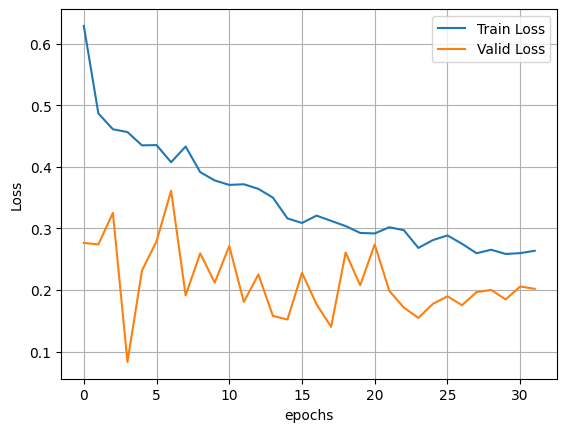

In [30]:
plt.plot( range(len(history["Train Loss"])), history["Train Loss"], label="Train Loss")
plt.plot( range(len(history["Valid Loss"])), history["Valid Loss"], label="Valid Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

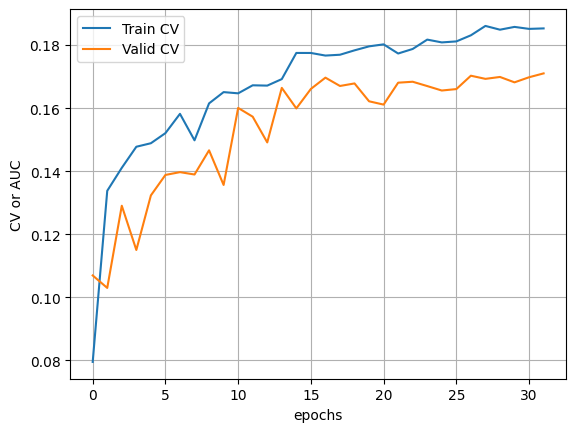

In [31]:
plt.plot( range(len(history["Train CV"])), history["Train CV"], label="Train CV")
plt.plot( range(len(history["Valid CV"])), history["Valid CV"], label="Valid CV")
plt.xlabel("epochs")
plt.ylabel("CV or AUC")
plt.grid()
plt.legend()
plt.show()

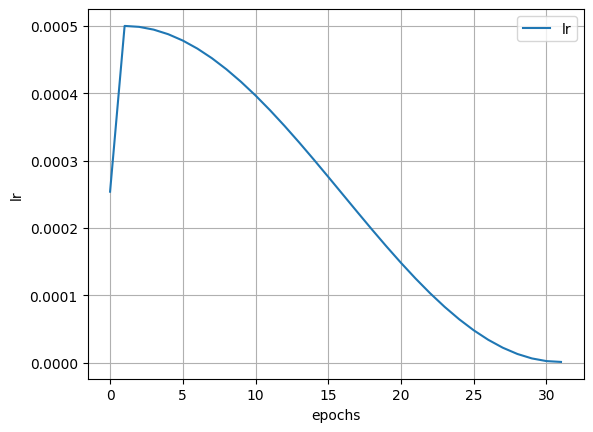

In [32]:
plt.plot( range(len(history["lr"])), history["lr"], label="lr")
plt.xlabel("epochs")
plt.ylabel("lr")
plt.grid()
plt.legend()
plt.show()